
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy/v0.12?urlpath=lab/tree/simulate_3d.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[simulate_3d.ipynb](../_static/notebooks/simulate_3d.ipynb) |
[simulate_3d.py](../_static/notebooks/simulate_3d.py)
</div>


# 3D simulation and fitting

This tutorial shows how to do a 3D map-based simulation and fit.

For a tutorial on how to do a 3D map analyse of existing data, see the `analysis_3d` tutorial.

This can be useful to do a performance / sensitivity study, or to evaluate the capabilities of Gammapy or a given analysis method. Note that is is a binned simulation as is e.g. done also in Sherpa for Chandra, not an event sampling and anbinned analysis as is done e.g. in the Fermi ST or ctools.

## Imports and versions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube.models import SkyModel, BackgroundModel
from gammapy.cube import MapDataset, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.utils.fitting import Fit
from gammapy.data import FixedPointingInfo

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	path                   : /Users/adonath/github/adonath/gammapy/gammapy 
	version                : 0.12       



## Simulate

In [4]:
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)

In [5]:
# Define sky model to simulate the data
spatial_model = SkyGaussian(lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg")
spectral_model = PowerLaw(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)
print(sky_model)

SkyModel

Parameters: 

	   name     value   error      unit         min        max    frozen
	--------- --------- ----- -------------- ---------- --------- ------
	    lon_0 2.000e-01   nan            deg -1.800e+02 1.800e+02  False
	    lat_0 1.000e-01   nan            deg -9.000e+01 9.000e+01  False
	    sigma 3.000e-01   nan            deg  0.000e+00       nan  False
	    index 3.000e+00   nan                       nan       nan  False
	amplitude 1.000e-11   nan cm-2 s-1 TeV-1        nan       nan  False
	reference 1.000e+00   nan            TeV        nan       nan   True


In [6]:
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(5, 4), coordsys="GAL", axes=[axis]
)

In [7]:
# Define some observation parameters
# We read in the pointing info from one of the 1dc event list files as an example
pointing = FixedPointingInfo.read(
    "$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_110380.fits"
)

livetime = 1 * u.hour
offset_max = 2 * u.deg
offset = Angle("2 deg")

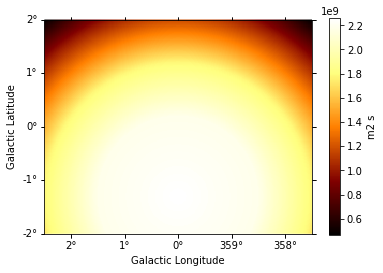

In [8]:
exposure = make_map_exposure_true_energy(
    pointing=pointing.radec, livetime=livetime, aeff=irfs["aeff"], geom=geom
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

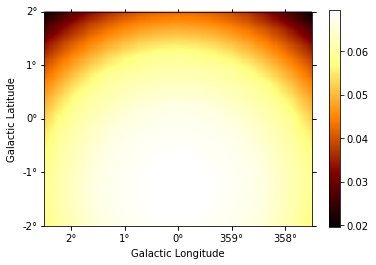

In [9]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
)
background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

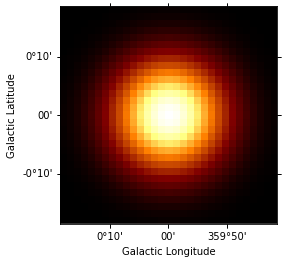

In [10]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=0.3 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

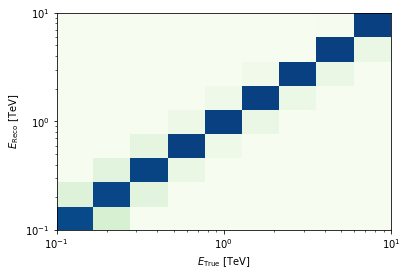

In [11]:
energy = axis.edges
edisp = irfs["edisp"].to_energy_dispersion(
    offset, e_reco=energy, e_true=energy
)
edisp.plot_matrix();

Now we have to compute `npred`  maps, i.e. "predicted counts per pixel" given the model and the observation infos: exposure, background, PSF and EDISP. For this we use the `MapDataset` object:

In [12]:
background_model = BackgroundModel(background)
dataset = MapDataset(
    model=sky_model,
    exposure=exposure,
    background_model=background_model,
    psf=psf_kernel,
    edisp=edisp,
)

In [13]:
npred = dataset.npred()

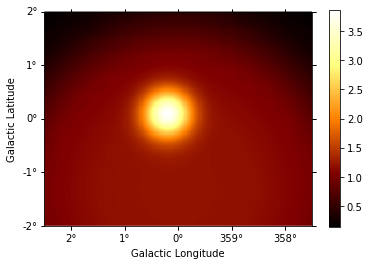

In [14]:
npred.sum_over_axes().plot(add_cbar=True);

In [15]:
# This one line is the core of how to simulate data when
# using binned simulation / analysis: you Poisson fluctuate
# npred to obtain simulated observed counts.
# Compute counts as a Poisson fluctuation
rng = np.random.RandomState(seed=42)
counts = rng.poisson(npred.data)
counts_map = WcsNDMap(geom, counts)

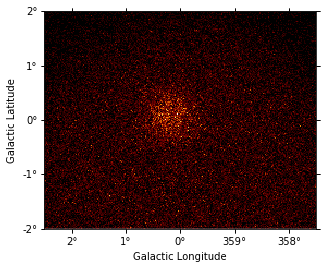

In [16]:
counts_map.sum_over_axes().plot();

## Fit

Now let's analyse the simulated data.
Here we just fit it again with the same model we had before, but you could do any analysis you like here, e.g. fit a different model, or do a region-based analysis, ...

In [17]:
# Define sky model to fit the data
spatial_model = SkyGaussian(lon_0="0.1 deg", lat_0="0.1 deg", sigma="0.5 deg")
spectral_model = PowerLaw(
    index=2, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
print(model)

SkyModel

Parameters: 

	   name     value   error      unit         min        max    frozen
	--------- --------- ----- -------------- ---------- --------- ------
	    lon_0 1.000e-01   nan            deg -1.800e+02 1.800e+02  False
	    lat_0 1.000e-01   nan            deg -9.000e+01 9.000e+01  False
	    sigma 5.000e-01   nan            deg  0.000e+00       nan  False
	    index 2.000e+00   nan                       nan       nan  False
	amplitude 1.000e-11   nan cm-2 s-1 TeV-1        nan       nan  False
	reference 1.000e+00   nan            TeV        nan       nan   True


In [18]:
# We do not want to fit the background in this case, so we will freeze the parameters
background_model.parameters["norm"].value = 1.0
background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

print(background_model)

BackgroundModel

Parameters: 

	   name     value   error unit    min    max frozen
	--------- --------- ----- ---- --------- --- ------
	     norm 1.000e+00   nan      0.000e+00 nan   True
	     tilt 0.000e+00   nan            nan nan   True
	reference 1.000e+00   nan  TeV       nan nan   True


In [19]:
dataset = MapDataset(
    model=model,
    exposure=exposure,
    counts=counts_map,
    background_model=background_model,
    psf=psf_kernel,
    edisp=edisp,
)

In [20]:
%%time
fit = Fit(dataset)
result = fit.run(optimize_opts={"print_level": 1})

FCN = 233997.8495429449 
 TOTAL NCALL = 214 
 NCALLS = 214 
 
 
 EDM = 5.36146884348607e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 par_000_lon_0 
 18.5861 
 0.881872 
 
 
 -18000 
 18000 
 No 
 
 
 1 
 par_001_lat_0 
 0.876831 
 0.0874743 
 
 
 -900 
 900 
 No 
 
 
 2 
 par_002_sigma 
 2.96346 
 0.0609922 
 
 
 0 
 
 No 
 
 
 3 
 par_003_index 
 3.05558 
 0.0305726 
 
 
 
 
 No 
 
 
 4 
 par_004_amplitude 
 0.905969 
 0.0461428 
 
 
 
 
 No 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & par 000 $lon_{0}$ & 18.5861 & 0.881872 & & & -18000.0 & 18000 & No\\
\hline
1 & par 001 $lat_{0}$ & 0.876831 & 0.0874743 & & & -900.0 & 900 & No\\
\hline
2 & par $002_{\sigma}$ & 2.96346 & 0.0609922 & & & 0.0 & & No\\
\hline
3 & par $003_{index}$ & 3.05558 & 0.0305726 & & & & & No\\
\hline
4 & par $004_{amplitude}$ & 0.905969 & 0.0461428 & & & & & No\\
\hline
\end{tabular}

CPU times: user 15.4 s, sys: 331 ms, total: 15.7 s
Wall time: 7.89 s


True model:

In [21]:
print(sky_model)

SkyModel

Parameters: 

	   name     value   error      unit         min        max    frozen
	--------- --------- ----- -------------- ---------- --------- ------
	    lon_0 2.000e-01   nan            deg -1.800e+02 1.800e+02  False
	    lat_0 1.000e-01   nan            deg -9.000e+01 9.000e+01  False
	    sigma 3.000e-01   nan            deg  0.000e+00       nan  False
	    index 3.000e+00   nan                       nan       nan  False
	amplitude 1.000e-11   nan cm-2 s-1 TeV-1        nan       nan  False
	reference 1.000e+00   nan            TeV        nan       nan   True


Best-fit model:

In [22]:
print(model)

SkyModel

Parameters: 

	   name     value   error      unit         min        max    frozen
	--------- --------- ----- -------------- ---------- --------- ------
	    lon_0 1.859e-01   nan            deg -1.800e+02 1.800e+02  False
	    lat_0 8.768e-02   nan            deg -9.000e+01 9.000e+01  False
	    sigma 2.963e-01   nan            deg  0.000e+00       nan  False
	    index 3.056e+00   nan                       nan       nan  False
	amplitude 9.060e-12   nan cm-2 s-1 TeV-1        nan       nan  False
	reference 1.000e+00   nan            TeV        nan       nan   True


To get the errors on the model, we can check the covariance table:

In [23]:
result.parameters.covariance_to_table()

<Table length=9>
   name     lon_0      lat_0     sigma    ... reference    norm      tilt  
   str9    float64    float64   float64   ...  float64   float64   float64 
--------- ---------- --------- ---------- ... --------- --------- ---------
    lon_0  7.777e-05 3.525e-07 -9.334e-08 ... 0.000e+00 0.000e+00 0.000e+00
    lat_0  3.525e-07 7.652e-05  1.826e-06 ... 0.000e+00 0.000e+00 0.000e+00
    sigma -9.334e-08 1.826e-06  3.720e-05 ... 0.000e+00 0.000e+00 0.000e+00
    index -4.088e-06 3.123e-06 -5.988e-07 ... 0.000e+00 0.000e+00 0.000e+00
amplitude  4.998e-17 4.978e-17  7.925e-16 ... 0.000e+00 0.000e+00 0.000e+00
reference  0.000e+00 0.000e+00  0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00
     norm  0.000e+00 0.000e+00  0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00
     tilt  0.000e+00 0.000e+00  0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00
reference  0.000e+00 0.000e+00  0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00

In [24]:
# Or, to see the value of and error on an individual parameter, say index:
print(result.parameters["index"].value, result.parameters.error("index"))

3.0555770550063204 0.03057263305196295


In [25]:
# TODO: show e.g. how to make a residual image